# Groups

In [6]:
import numpy as np

model_name = "pythia_410m"
n_tokens = int(5e6)

dist = np.load(f"dist/{model_name}_{n_tokens}.npy")
dist = np.nanmean(dist, 0)
nl = dist.shape[0]
dist.shape

(24, 24)

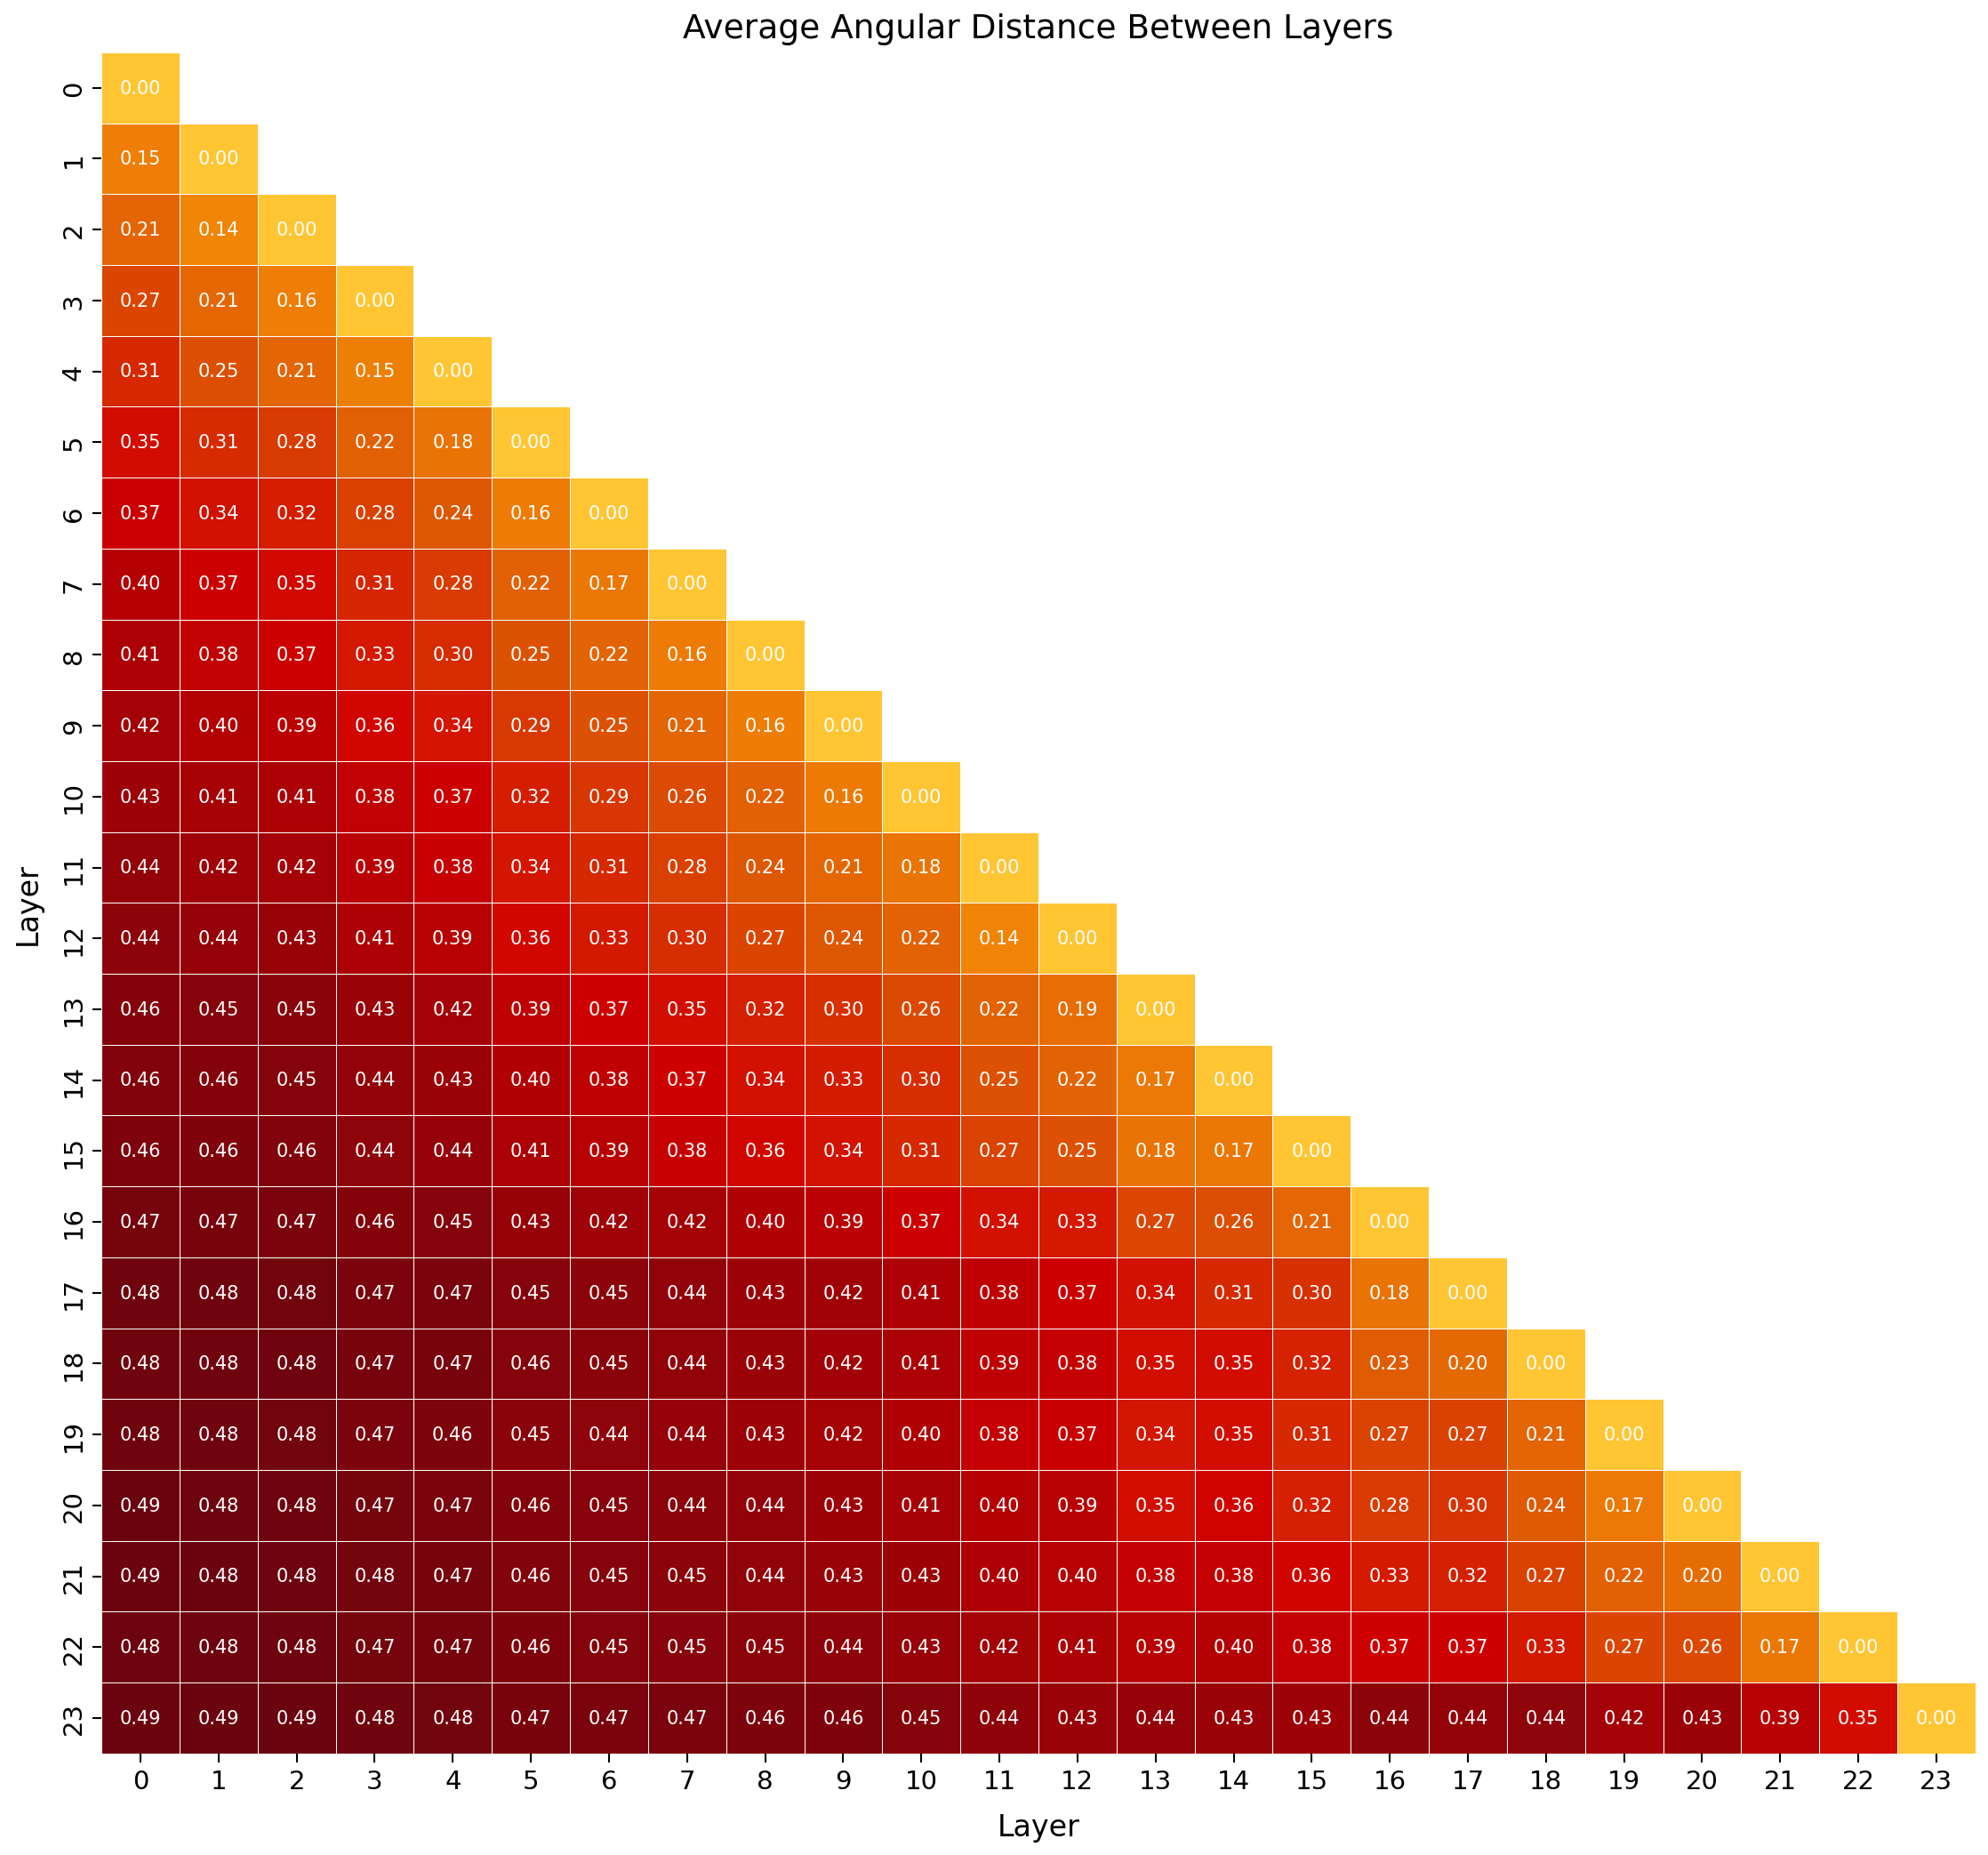

In [7]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

from group_sae.utils import cmap

os.makedirs("img", exist_ok=True)

sns.set_context("paper")
scale = nl / 25
fig, ax = plt.subplots(1, 1, figsize=(int(16 * scale), int(15 * scale)), dpi=150, layout="tight")  # 12, 11

cmap.set_bad("white")
dist_bad = np.copy(dist)
dist_bad[np.triu_indices_from(dist_bad, 1)] = np.nan
mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)

sns.heatmap(
    dist_bad,
    cmap=cmap,
    vmin=0,
    annot=True,
    fmt=".2f",
    ax=ax,
    mask=np.triu(dist),
    square=False,
    linewidths=0.3,
    linecolor="white",
    cbar=False,
    annot_kws={"size": 10, "color": "white"},
)

ax.set_title("Average Angular Distance Between Layers", pad=8, fontsize=18)
# ax.set_ylim(0, 1)

ax.set_xlabel("Layer", labelpad=10, fontsize=16)
ax.set_ylabel("Layer", labelpad=10, fontsize=16)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.savefig(f"img/{model_name}_{n_tokens}.pdf", dpi=300, bbox_inches="tight")

In [9]:
import json

from sklearn.cluster import AgglomerativeClustering

scores = []

X = np.array(dist[:-1, :-1])
X[np.isinf(X)] = 0
X[np.isnan(X)] = 0
X = np.nan_to_num(X)

clusters = {}

for k in range(1, nl // 2):
    clustering = AgglomerativeClustering(
        n_clusters=k, linkage="complete", compute_distances=True
    ).fit(X)

    cluster_dist = [X[clustering.labels_ == i][:, clustering.labels_ == i].max() for i in range(k)]
    print(f"K{k}:\t", clustering.labels_, "MAAD:", np.round(max(cluster_dist), 3))

    clusters[k] = {
        "labels": [str(i) for i in clustering.labels_],
        "maad": float(np.round(max(cluster_dist), 3))
    }

with open(f"maad/{model_name}.json", "w") as f:
    json.dump(clusters, f)

K1:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] MAAD: 0.487
K2:	 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] MAAD: 0.441
K3:	 [0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 1 1 1 1 1 1] MAAD: 0.409
K4:	 [1 1 1 1 1 3 3 3 3 2 2 2 2 2 2 2 0 0 0 0 0 0 0] MAAD: 0.368
K5:	 [1 1 1 1 1 3 3 3 3 0 0 0 0 0 0 0 4 4 4 2 2 2 2] MAAD: 0.339
K6:	 [0 0 0 0 0 1 1 1 1 3 3 3 3 5 5 5 4 4 4 2 2 2 2] MAAD: 0.307
K7:	 [5 5 5 6 6 1 1 1 1 3 3 3 3 2 2 2 4 4 4 0 0 0 0] MAAD: 0.269
K8:	 [5 5 5 6 6 0 0 0 0 1 1 1 1 2 2 2 4 4 4 7 7 3 3] MAAD: 0.252
K9:	 [5 5 5 6 6 4 4 8 8 0 0 0 0 2 2 2 1 1 1 7 7 3 3] MAAD: 0.242
K10:	 [5 5 5 6 6 4 4 8 8 3 3 9 9 2 2 2 0 0 0 7 7 1 1] MAAD: 0.232
K11:	 [ 2  2  2  6  6  4  4  8  8  3  3  9  9  0  0  0 10  5  5  7  7  1  1] MAAD: 0.213
